### Written by  [Gabriel Borges Pinheiro](https://www.github.com/gabrielbopi)

In [40]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [41]:
def db(X):
    return 10 * np.log10(np.abs(X))
def inv_db(X):
    return 10**(X/10)
def dbm(X):
    return 10 * np.log10(np.abs(X)/(1e-3))
def inv_dbm(X):
    return (1e-3) * 10**(X/10)

def NminInd(list_orig, N):
    """Find N minimum elements"""
    list1 = np.copy(list_orig)
    final_list =[];
  
    for i in range(0, N):   
        minInd = np.argmin(list1)
        final_list.append(minInd)
        list1[minInd] = 99999
        
    return final_list

In [42]:
def bases(D, x, y, z_med=15):
    num_x = int(x/D)
    num_y = int(y/D)
    total = num_x*num_y
    n = np.array([])
    for i in range(num_y):
        for j in range(num_x):
#             n = np.append(n, np.array([(j*D)+(D/2),(i*D)+(D/2),z_med]))
            n = np.append(n, np.array([(j*D),(i*D),z_med])) 
    return n.reshape(total,3) , total

def usuário(n, x, y, z_med = 1.5,os_x=0,os_y=0):
    UE = np.array([])
    for i in range(n):
        UE = np.append(UE,np.array([x*np.random.random()+os_x,y*np.random.random()+os_y,z_med]))
    return UE.reshape(n,3)

def steeringVector(N,d,λ,sweep_θ=180):
    """sweep_θ: Num pts de θ (Azimute)"""
    n = np.arange(N)
    sweep_θ = 180 #Num pts de θ
    v = np.zeros([sweep_θ,N],dtype='complex')
    for i in range(sweep_θ):
        θ = np.pi*i/180
        v[i] = np.exp(-1j*2*np.pi*(d/λ)*n*np.sin(θ))
    return v

## Beamforming and AoA test

Done
fc = 5.8000e+09
nSubcarrier = 600
subcarrierSpacing = 120000
f_carrier = 5800.0MHz, no. subcarr. = 600, freq. subcarr. = 120.0kHz


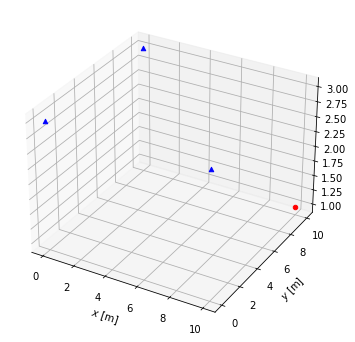

In [37]:
#Espaçamento entre cada BS
gap_bs = 10 #m
MT_height = 1;
#Lados da area de bases (quadrado com bases a cada gap_bs metros)
n_bs = 3
BS = np.array([[0,0,3],[10,0,3],[0,10,3]])
n_ue = 1
UE = np.array([[10,10,MT_height]])
#Carrier frequency
f0 = 5.8e9 #Hz
#User band
Δf = 120e3 #Hz
#Numero de portadoras (OFDM)
n_f = 600
#Spectral density of noise
N0=-127#dBm
#Array de antenas transmissoras e receptoras (mxn)
Mtx = 1; Ntx = 1;
Mrx = 5; Nrx = 5;

from scipy.io import savemat
#multi APs
n_tx = Mtx*Ntx #TX array
n_rx = Mrx*Nrx #RX array
nSubcarr = n_f
c = 3e8
λmin = c/(f0+Δf*n_f/2)
d = λmin/2
par = {'fc':f0, 'nSubcarr':n_f, 'freqSubcarr':Δf,'BS':BS, 'UE':UE, 'array':{'d':d,'Mtx':Mtx,'Ntx':Ntx,'Mrx':Mrx,'Nrx':Nrx}}
savemat("./models/parameters.mat",par)

! .\octave_windows\mingw64\bin\octave-cli .\scripts\genChannelModel_bf.m

from scipy.io import loadmat

config = loadmat("./models/config.mat")
H_q = loadmat("./models/channel.mat")
H_qf = H_q['Hfreq']
Hdelay = H_q['cluster_delay']
fc = f0
freqSubcarr = Δf
d = config['d_array'][0,0]
print('f_carrier = {}MHz, no. subcarr. = {}, freq. subcarr. = {}kHz'.format(f0*1e-6,nSubcarr,freqSubcarr*1e-3))
H = np.zeros([n_ue,n_bs,n_rx,n_f],dtype='complex')
delay_real = np.zeros([n_ue,n_bs])
for j in range(n_bs):
    for m in range(n_rx):
        for n in range(n_tx):
            for i in range(n_f):
                for k in range(n_ue):
                    H[k,j,m,i] =  H_qf[k,0][m,n,i,j]
                    delay_real[k,j] = Hdelay[k,0][0,j]
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')
plt.ylabel("$y$ [m]")
plt.xlabel("$x$ [m]")
for i in range(n_bs):
    ax.scatter(BS[i][0], BS[i][1], BS[i][2], marker='^',color='blue')
for n in range(n_ue):
    ax.scatter(UE[n][0], UE[n][1], UE[n][2], marker='o',color='red')

Text(0.5, 1.0, 'Channel response of beamforming filtering for 25 antennas')

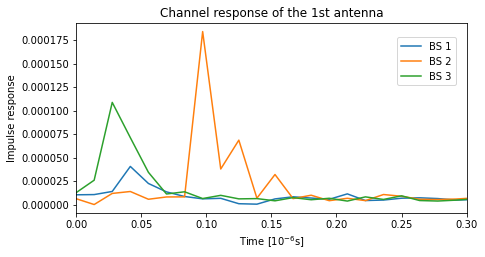

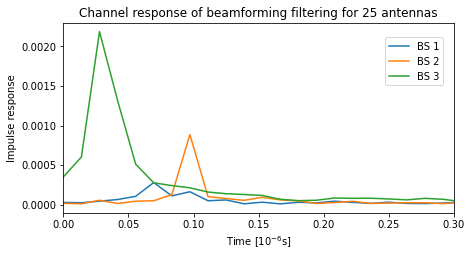

In [38]:
P_db = 30#dBm
P = inv_dbm(P_db)/n_f
# S(f) generated as a digital randomic diagonal matrix (with 1 or -1)
D = np.random.randint(low=0,high=2,size=n_f)*2-1
S = np.zeros([n_bs,n_f,n_f])
S[::] = np.diag(D)*np.sqrt(P) #For each AP
S_inv = np.zeros([n_bs,n_f,n_f])
#Noise
var_ruido = inv_dbm(-127)*Δf/2

Y = np.zeros([n_bs,n_f])
R = np.zeros([n_bs,n_f])
h = np.zeros([n_ue,n_bs,n_rx,n_f], dtype='complex')
for k in range(n_ue):
    for j in range(n_bs):
        for n in range(n_rx):
            η = np.random.normal(0,np.sqrt(var_ruido),size=n_f)+1j*np.random.normal(0,np.sqrt(var_ruido),size=n_f)
            # Received signal Y(f)
            Y = H[k,j,n] @ S[j] + η

            S_inv[j] = np.linalg.inv(S[j])
            R =  Y@S_inv[j]
            h[k,j,n] = np.fft.ifft(R)
#Sample rate
fs = n_f*Δf
Ts = 1/fs
t = np.linspace(0,n_f-1,n_f)*Ts

plt.figure(figsize=(7,3.5))
for i in range(n_bs):
    label = ('BS {}'.format(i+1))
    plt.plot(t*1e6,np.abs(h[0][i][0]),label=label)
plt.ylabel("Impulse response")
plt.xlabel("Time [$10^{-6}$s]")
plt.xlim(0,0.3)
plt.legend(bbox_to_anchor=(0.81, 0.95), loc='upper left')
plt.title('Channel response of the 1st antenna'.format(n_rx))

#WITH BEAMFORMING
v = steeringVector(n_rx,d,λmin,sweep_θ=180);

h_bf = np.zeros([n_bs,n_f],'complex')
for j in range(n_bs):
    h_dir = v.conj() @ h[0,j,:,:]
#     ind = np.unravel_index(np.argmax(abs(h_dir), axis=None), h_dir.shape)
#     print('AP={}, direction={}deg'.format(j+1,ind[0]))
#     h_bf[j] = h_dir[ind[0],:]
    ind = np.argmax(np.sum(np.abs(h_dir)**2,axis=1))
    h_bf[j] = h_dir[ind,:]
        
plt.figure(figsize=(7,3.5))
for j in range(n_bs):
    label = ('BS {}'.format(j+1))
    plt.plot(t*1e6,np.abs(h_bf[j]),label=label)
plt.ylabel("Impulse response")
plt.xlabel("Time [$10^{-6}$s]")
plt.xlim(0,0.3)
plt.legend(bbox_to_anchor=(0.81, 0.95), loc='upper left')
plt.title('Channel response of beamforming filtering for {} antennas'.format(n_rx))

## Localização

In [39]:
def bases(D, x, y, z_med=15):
    num_x = int(x/D)
    num_y = int(y/(2*D))
    total = num_x*num_y
    n = np.array([])
    for i in range(num_y):
        for j in range(num_x):
#             n = np.append(n, np.array([(j*D)+(D/2),(i*D)+(D/2),z_med]))
            n = np.append(n, np.array([(j*D),(i*2*D),z_med])) 

    return n.reshape(total,3) , total

In [43]:
#Espaçamento entre cada BS
gap_bs = 10 #m
MT_height = 1;
#Lados da area de bases (quadrado com bases a cada gap_bs metros)
BS,n_bs = bases(gap_bs, 40, 20,3)
#Dropa usuario aleatorio na area dos lados especificados
n_ue = 3
UE = usuário(n_ue, 30, 10,z_med=MT_height)
#Carrier frequency
f0 = 5.8e9 #Hz
#User band
Δf = 120e3 #Hz
#Numero de portadoras (OFDM)
n_f = 600
#Spectral density of noise
N0=-127#dBm
#Array de antenas transmissoras e receptoras (mxn)
Mtx = 1; Ntx = 1;
Mrx = 1; Nrx = 1;

#### Calculating parameters

Done
fc = 5.8000e+09
nSubcarrier = 600
subcarrierSpacing = 120000
f_carrier = 5800.0MHz, no. subcarr. = 600, freq. subcarr. = 120.0kHz


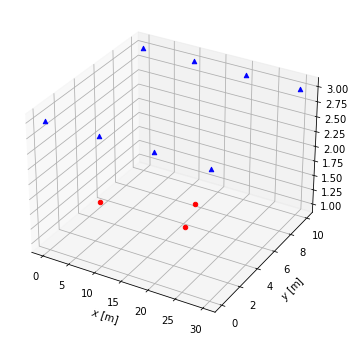

In [45]:
n_tx = Mtx*Ntx #TX array
n_rx = Mrx*Nrx #RX array
nSubcarr = n_f
c = 3e8
N = n_rx
λmin = c/(f0+Δf*n_f/2)
d = λmin/2
par = {'fc':f0, 'nSubcarr':n_f, 'freqSubcarr':Δf,'BS':BS, 'UE':UE, 'array':{'d':d,'Mtx':Mtx,'Ntx':Ntx,'Mrx':Mrx,'Nrx':Nrx}}

from scipy.io import savemat
savemat("./models/parameters.mat",par)

#It works only for Windows. For another OS, you must run the script manually ('.\genChannelModel.m')
! .\octave_windows\mingw64\bin\octave-cli .\genChannelModel.m

from scipy.io import loadmat

config = loadmat("./models/config.mat")
H_q = loadmat("./models/channel.mat")
H_qf = H_q['Hfreq']
Hdelay = H_q['cluster_delay']
fc = f0
freqSubcarr = Δf
print('f_carrier = {}MHz, no. subcarr. = {}, freq. subcarr. = {}kHz'.format(f0*1e-6,nSubcarr,freqSubcarr*1e-3))

n_bs = np.size(BS,axis=0)
n_ue = np.size(UE,axis=0)
#multi APs
n_tx = Mtx*Ntx #TX array
n_rx = Mrx*Nrx #RX array
#Numero de frequencias
H = np.zeros([n_ue,n_bs,n_rx,n_f],dtype='complex')
delay_real = np.zeros([n_ue,n_bs])
for j in range(n_bs):
    for n in range(n_tx):
        for m in range(n_rx):
            for i in range(n_f):
                for k in range(n_ue):
                    H[k,j,m,i] =  H_qf[k,0][m,n,i,j]
                    delay_real[k,j] = Hdelay[k,0][0,j]
        
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')
plt.ylabel("$y$ [m]")
plt.xlabel("$x$ [m]")
for i in range(n_bs):
    ax.scatter(BS[i][0], BS[i][1], BS[i][2], marker='^',color='blue')
for n in range(n_ue):
    ax.scatter(UE[n][0], UE[n][1], UE[n][2], marker='o',color='red')

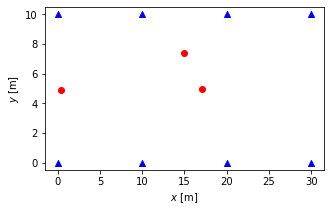

In [46]:
fig2 = plt.figure(figsize=(5,3))
ax2 = fig2.add_subplot(111, projection='rectilinear')
plt.ylabel("$y$ [m]")
plt.xlabel("$x$ [m]")
# plt.zlabel("$z$ [m]")
for i in range(n_bs):
    ax2.scatter(BS[i][0], BS[i][1], marker='^',color='blue')
for n in range(n_ue):
    ax2.scatter(UE[n][0], UE[n][1], marker='o',color='red')

Processing delays

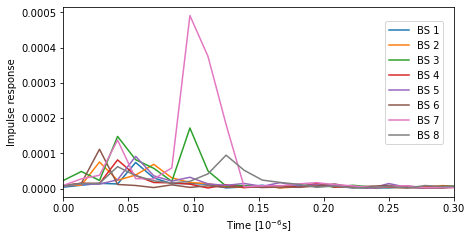

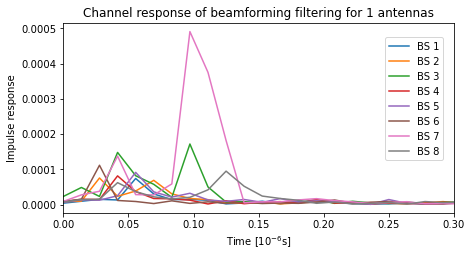

In [47]:
P_db = 30#dBm
P = inv_dbm(P_db)/n_f
# S(f) generated as a digital randomic diagonal matrix (with 1 or -1)
D = np.random.randint(low=0,high=2,size=n_f)*2-1
#Signal matrix $s(t)$:
S = np.zeros([n_bs,n_f,n_f])
S[::] = np.diag(D)*np.sqrt(P) #For each AP
S_inv = np.zeros([n_bs,n_f,n_f])
#Noise
var_ruido = inv_dbm(-127)*Δf/2

Y = np.zeros([n_bs,n_f])
R = np.zeros([n_bs,n_f])
h = np.zeros([n_ue,n_bs,n_rx,n_f], dtype='complex')
for k in range(n_ue):
    for j in range(n_bs):
        for n in range(n_rx):
            η = np.random.normal(0,np.sqrt(var_ruido),size=n_f)+1j*np.random.normal(0,np.sqrt(var_ruido),size=n_f)
            # Received signal Y(f)
            Y = H[k,j,n] @ S[j] + η
            S_inv[j] = np.linalg.inv(S[j])
            R =  Y@S_inv[j]
            h[k,j,n] = np.fft.ifft(R)
#Sample rate
fs = n_f*Δf
Ts = 1/fs
t = np.linspace(0,n_f-1,n_f)*Ts
#PLOT
plt.figure(figsize=(7,3.5))
for i in range(n_bs):
    label = ('BS {}'.format(i+1))
    plt.plot(t*1e6,np.abs(h[0][i][0]),label=label)

plt.ylabel("Impulse response")
plt.xlabel("Time [$10^{-6}$s]")
plt.xlim(0,0.3)
plt.legend(bbox_to_anchor=(0.81, 0.95), loc='upper left')
# plt.grid()

#WITH BEAMFORMING
v = steeringVector(n_rx,d,λmin,sweep_θ=180)  
h_bf = np.zeros([n_bs,n_f],'complex')
for j in range(n_bs):
    h_dir = v.conj() @ h[0,j,:,:]
#     ind = np.unravel_index(np.argmax(abs(h_dir), axis=None), h_dir.shape)
#     h_bf[j] = h_dir[ind[0],:]
    ind = np.argmax(np.sum(np.abs(h_dir)**2,axis=1))
    h_bf[j] = h_dir[ind,:]
        
plt.figure(figsize=(7,3.5))
for j in range(n_bs):
    label = ('BS {}'.format(j+1))
    plt.plot(t*1e6,np.abs(h_bf[j]),label=label)
plt.ylabel("Impulse response")
plt.xlabel("Time [$10^{-6}$s]")
plt.xlim(0,0.3)
plt.legend(bbox_to_anchor=(0.81, 0.95), loc='upper left')
plt.title('Channel response of beamforming filtering for {} antennas'.format(n_rx));

Text(0.5, 1.0, 'Any channel response of beamforming filtering for 1 antennas')

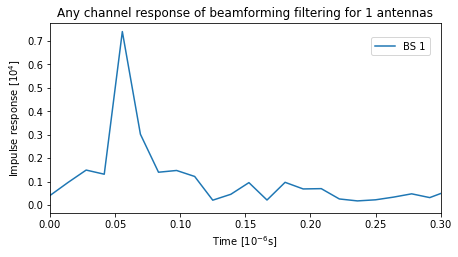

In [48]:
plt.figure(figsize=(7,3.5))
for j in [0]:
    label = ('BS {}'.format(j+1))
    plt.plot(t*1e6,np.abs(h_bf[j])*1e4,label=label)
plt.ylabel("Impulse response [$10^4$]")
plt.xlabel("Time [$10^{-6}$s]")
plt.xlim(0,0.3)
plt.legend(bbox_to_anchor=(0.81, 0.95), loc='upper left')
plt.title('Any channel response of beamforming filtering for {} antennas'.format(n_rx))

In [49]:
c = 3e8 #m/s
τ_est = np.zeros([n_ue,n_bs],dtype='float64')
D_est = np.zeros_like(τ_est)

for k in range(n_ue):
#     i_τ = np.apply_along_axis(lambda i:np.argmax(np.abs(i)), 1, h[k])
    i_τ = np.apply_along_axis(lambda i:np.argmax(np.abs(i)), 1, h_bf)
    τ_est[k] = np.apply_along_axis(lambda k:t[k], 0, i_τ)
D_est = τ_est*c
τ = delay_real
D = τ*c
#Erro de distancia (metros)
erro_D = np.abs(D-D_est)

#Distance for UE(i)
i = 2
import pandas as pd
data = np.array([range(1,n_bs+1),τ_est[i]*(1e7), D_est[i], D[i], erro_D[i]]).transpose()
dados = pd.DataFrame(columns=['BS','$\tau$ estimated ($10^{-7}$ s)','D estimated (m)','D real (m)','Error distance (m)'],data=data)
dados = dados.set_index('BS')
dados.head(n_bs)

,$\tau$ estimated ($10^{-7}$ s),D estimated (m),D real (m),Error distance (m)
BS,,,,
1.0,0.555556,16.666667,5.305594,11.361073
2.0,0.277778,8.333333,10.932749,2.599416
3.0,0.972222,29.166667,20.277517,8.889149
4.0,0.416667,12.500000,30.051746,17.551746
5.0,0.555556,16.666667,5.508025,11.158642
6.0,0.277778,8.333333,11.032408,2.699075
7.0,0.972222,29.166667,20.331422,8.835245
8.0,1.250000,37.500000,30.088144,7.411856


#### Trilateration
#### LLS
$\mathbf{A} \mathbf{r}_{est} = \mathbf{c}$

In [50]:
def trilat_lls(D, BS, N_bs=3):
    import math
    
    r_est = np.zeros([n_ue,2])
    for j in range(n_ue):
    # for j in range(N_bs):
    #New denotations
        lista = NminInd(D[j,:], N_bs)
        d = D[j,lista]
        x = BS[lista,0]
        y = BS[lista,1]

        A = np.array([])
        c = np.array([])
        for i in np.arange(N_bs-1):
            for k in np.arange(i+1,N_bs):
                A = np.append(A,[2*(x[i]-x[k]),2*(y[i]-y[k])])
                c = np.append(c,(d[k]**2-d[i]**2)+(-x[k]**2-y[k]**2+x[i]**2+y[i]**2))
        A = A.reshape(math.comb(N_bs,2),2)
        r_est[j] = np.linalg.pinv(A)@c
    return r_est

def trilat_nls(D, BS, r_0, N_bs=3, n_it=15):
    θ = r_0
    theta = np.zeros([n_ue,2])
    lista_min = np.zeros([n_ue,N_bs],dtype='int')
    for j in range(n_ue):
        #New denotations
        lista_min[j] = NminInd(D[j,:], N_bs)
    for a in range(n_it):
        for j in range(n_ue):
        #New denotations
            r = D[j,lista_min[j]]
            x = BS[lista_min[j],0]
            y = BS[lista_min[j],1]
            r_bs = np.array([x,y]).transpose()

            H = np.array([])
            f_θ = np.array([])
            for i in np.arange(N_bs):
                H = np.append(H,(r_bs[i]-θ[j])*1/np.linalg.norm(r_bs[i]-θ[j]))
                f_θ = np.append(f_θ,np.linalg.norm(r_bs[i]-θ[j]))
            H = H.reshape(N_bs,2)
            theta[j] = θ[j] - np.linalg.pinv(H)@(r-f_θ)
        θ = theta
    return theta

Distance error for:
UE0->0.9842088274413835m
UE1->4.074859207102785m
UE2->16.72843156569822m


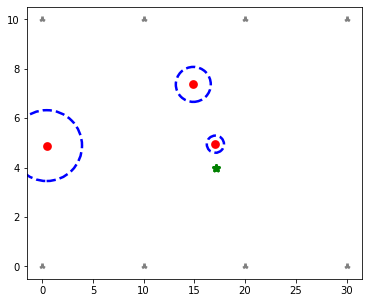

In [51]:
#PLOT    
r_est = trilat_lls(D_est, BS, 4)
fig = plt.figure(figsize=(6,5))
ax = fig.add_subplot(111)

erro_range = np.zeros(n_ue)
print('Distance error for:')
for n in range(n_ue):
    erro_range[n] = np.linalg.norm(UE[n,:2]-r_est[n])
    ax.scatter(UE[n][0], UE[n][1], marker='o',color='red', linewidths=2.75)
    ax.scatter(UE[n][0], UE[n][1], s=erro_range[n]*300, marker='o',edgecolor='blue',facecolor='none',linestyle='--', linewidths=2.5)
    ax.scatter(r_est[n][0], r_est[n][1], marker='*',color='green', linewidths=2.75)
    print('UE{}->{}m'.format(n,erro_range[n]))
    
for n in range(n_bs):
    ax.scatter(BS[n][0], BS[n][1], marker='2',color='gray', linewidths=2.75)

#### NLS de $1^a$ ordem

Distance error for:
UE0->0.748613279277857m
UE1->3.768563176004863m
UE2->16.529362873158554m


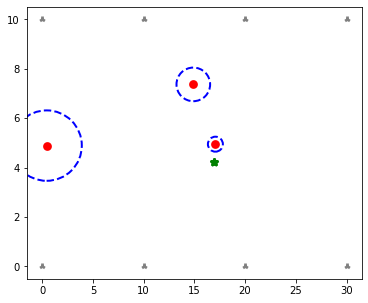

In [52]:
theta = trilat_nls(D_est, BS, r_est, N_bs=4)
#PLOT
fig = plt.figure(figsize=(6,5))
ax = fig.add_subplot(111)

erro_range = np.zeros(n_ue)
print('Distance error for:')
for n in range(n_ue):
    erro_range[n] = np.linalg.norm(UE[n,:2]-theta[n])
    ax.scatter(UE[n][0], UE[n][1], marker='o',color='red', linewidths=2.75)
    ax.scatter(UE[n][0], UE[n][1], s=erro_range[n]*300, marker='o',edgecolor='blue',facecolor='none',linestyle='--', linewidths=2)
    ax.scatter(theta[n][0], theta[n][1], marker='*',color='green', linewidths=2.75) 
    print('UE{}->{}m'.format(n,erro_range[n]))
for n in range(n_bs):
    ax.scatter(BS[n][0], BS[n][1], marker='2',color='gray', linewidths=2.75)